In [24]:
import xarray as xr
import numpy as np
from scipy.io import loadmat
from scipy import interpolate, constants
from scipy import signal
import matplotlib as mpl
import matplotlib.pyplot as plt
import seastar as ss
import seastar.oscar
import seastar.retrieval
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import re
import warnings
import os
import platform
import datetime

In [229]:
# Data load and pre-processing
version = 'v20221104'
oscar_path = "D:\\data\\SEASTAR\\SEASTARex\\Data\\Metasensing\\OSCAR\\May22_full_precompute_old\\"
#oscar_path = "D:\\data\\SEASTAR\\SEASTARex\\Data\\Metasensing\\OSCAR\\FINAL\\precompute\\20222205\\"

#oscar_path = "D:\\data\\oscar\\v20221104\\matlab-pre-processed\\"

file_time_triplets = ss.utils.tools.find_file_triplets(oscar_path)

print('OSCAR L1 processing - version ' + version)
print('-------------------')
print('File path :', oscar_path)
print('-------------------')
for i in range(len(file_time_triplets)):
    print('File index :', i, ',', 'Aquisition time :', file_time_triplets[i][0], ',', 'File list indices :', file_time_triplets[i][1])

# Match tracks in the star pattern from track names and times in the DAR_v6.0 to file aquisition times
star_pattern_tracks={
    'Track_L1' : 0,
    'Track_1a' : 1,
    'Track_2a' : 2,
    'Track_1b' : 3,
    'Track_11' : 4,
    'Track_12' : 5,
    'Track_13' : 6,
    'Track_14' : 7,
    'Track_15' : 8,
    'Track_16' : 9,
    'Track_17' : 10,
    'Track_18' : 11}
# L1a variables to be passed to L1b dataset
vars_to_keep = [
        'LatImage',
        'LonImage',
        'IncidenceAngleImage',
        'SquintImage',
        ]
# Compute L1C - Sigma0 + RVL
ds_L1b = dict()

# Loop through star pattern tracks
#for track in star_pattern_tracks.keys():
for track in ['Track_13']:
    ds_ml = dict()
    file_index = star_pattern_tracks[track]
    ds_L1a = ss.utils.readers.load_OSCAR_data(oscar_path, file_time_triplets[file_index][1])
    ds_L1a_dict_index = list(ds_L1a.keys())
    antenna_ident = ss.utils.tools.identify_antenna_location_from_filename(
                        oscar_path,
                        file_time_triplets[file_index][1])
    print('Processing file index',file_index)
    
    # L1b processing - loop through beams in L1a dataset dict
    #--------------------------------------------------------
    for dict_index in ds_L1a_dict_index:
        ds_L1a[dict_index] = ss.oscar.level1.replace_dummy_values(
                                 ds_L1a[dict_index],
                                 dummy_val=int(ds_L1a[dict_index].Dummy.data))
        ds_ml[dict_index] = ss.oscar.level1.compute_multilooking_Master_Slave(
                                ds_L1a[dict_index],
                                window=7)
        ds_ml[dict_index]['Polarization'] = ss.oscar.level1.check_antenna_polarization(ds_L1a[dict_index])
        ds_ml[dict_index]['Baseline'] = ss.oscar.level1.compute_antenna_baseline(0.2)
        ds_ml[dict_index]['AntennaAzimuthImage'] =ss.oscar.level1.compute_antenna_azimuth_direction(
                                                    ds_L1a[dict_index],
                                                    antenna=antenna_ident[ds_L1a_dict_index.index(dict_index)])
        ds_ml[dict_index]['TimeLag'] = ss.oscar.level1.compute_time_lag_Master_Slave(
                                           ds_L1a[dict_index],
                                           options='from_SAR_time')
        ds_ml[dict_index]['RadialSurfaceVelocity'] = ss.oscar.level1.compute_radial_surface_velocity(
                                                         ds_L1a[dict_index],
                                                         ds_ml[dict_index])
   
        ds_ml[dict_index][vars_to_keep] = ds_L1a[dict_index][vars_to_keep]
    #-----------------------------------------------------------
    ds_ml = ss.oscar.level1.fill_missing_variables(ds_ml, antenna_ident)
    
    # Build L1b dataset
    ds_L1b[track] = merge_beams(ds_ml, antenna_ident)
    #del ds_ml


OSCAR L1 processing - version v20221104
-------------------
File path : D:\data\SEASTAR\SEASTARex\Data\Metasensing\OSCAR\May22_full_precompute_old\
-------------------
File index : 0 , Aquisition time : 20220522T052218 , File list indices : [0, 1, 2]
File index : 1 , Aquisition time : 20220522T053942 , File list indices : [3, 4, 5]
File index : 2 , Aquisition time : 20220522T054805 , File list indices : [6, 7, 8]
File index : 3 , Aquisition time : 20220522T055458 , File list indices : [9, 10, 11]
File index : 4 , Aquisition time : 20220522T062018 , File list indices : [12, 13, 14]
File index : 5 , Aquisition time : 20220522T062620 , File list indices : [15, 16, 17]
File index : 6 , Aquisition time : 20220522T063239 , File list indices : [18, 19, 20]
File index : 7 , Aquisition time : 20220522T063906 , File list indices : [21, 22, 23]
File index : 8 , Aquisition time : 20220522T064459 , File list indices : [24, 25, 26]
File index : 9 , Aquisition time : 20220522T065108 , File list indic

In [90]:
folder = 'restricted\\'
aux_data_folder = "D:\\data\\SEASTAR\\SEASTARex\\Data\\Iframer\\"

arome_dict = dict()
arome_file_list = os.listdir(aux_data_folder + folder + 'METEOFRANCE_AROME\\')
for file in arome_file_list:
    arome_dict[arome_file_list.index(file)] =\
    xr.open_dataset(aux_data_folder + folder + 'METEOFRANCE_AROME\\' + file)

arome_winds = xr.concat(list(arome_dict.values()),
                        dim='time',
                       join='outer')
del arome_dict


In [95]:
arome_winds.time

<xarray.DataArray 'time' (time: 14)>
array(['2022-05-17T07:00:00.000000000', '2022-05-17T08:00:00.000000000',
       '2022-05-17T09:00:00.000000000', '2022-05-22T05:00:00.000000000',
       '2022-05-22T06:00:00.000000000', '2022-05-22T07:00:00.000000000',
       '2022-05-25T08:00:00.000000000', '2022-05-25T09:00:00.000000000',
       '2022-05-25T10:00:00.000000000', '2022-05-25T11:00:00.000000000',
       '2022-05-25T12:00:00.000000000', '2022-05-26T16:00:00.000000000',
       '2022-05-26T17:00:00.000000000', '2022-05-26T18:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2022-05-17T07:00:00 ... 2022-05-26T18:00:00
Attributes:
    long_name:      julian day (UT)
    standard_name:  time
    conventions:    relative julian days with decimal part (as parts of the day)
    axis:           T

C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\cartopy\crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\cartopy\crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\cartopy\crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


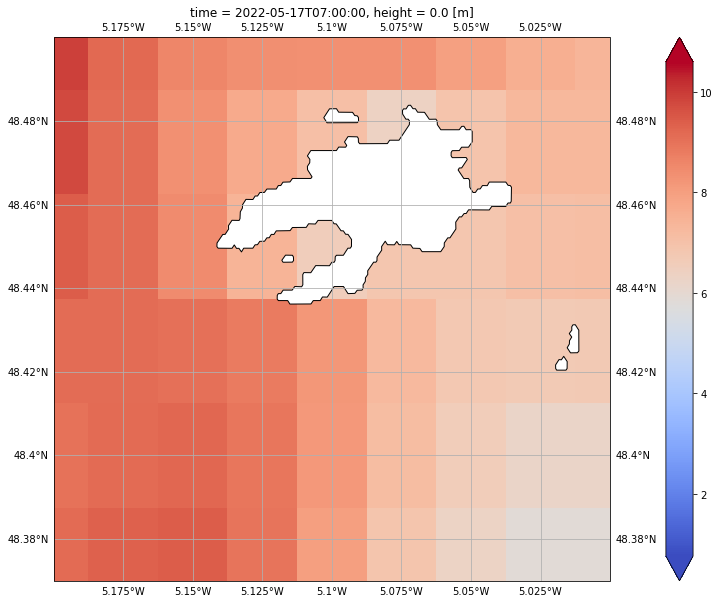

In [77]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
np.sqrt(
    Arome_1.isel(time=0).u10m ** 2
    + Arome_1.isel(time=0).v10m ** 2)\
 .plot(
    y='latitude',
    x='longitude',
    robust=True, 
    cmap='coolwarm',
    transform=ccrs.PlateCarree()
)

gl=ax.gridlines(draw_labels=True)
ax.set_extent([-5.2, -5.0, 48.37, 48.5], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.GSHHSFeature(scale='full',facecolor='white'))

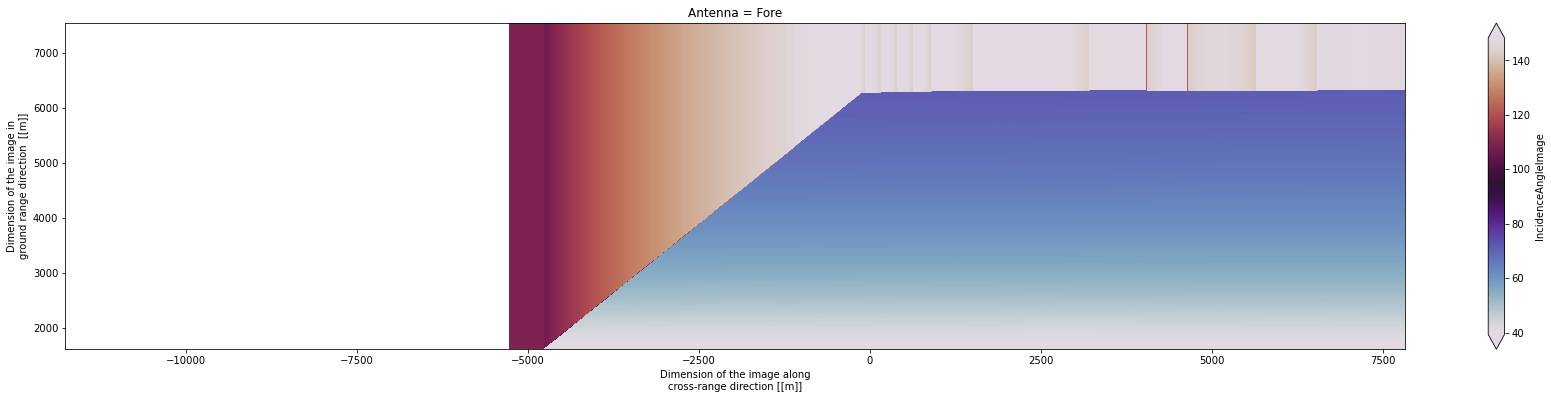

In [230]:
ax1 = ds_L1b[track].IncidenceAngleImage.sel(Antenna='Fore').plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                        cmap='twilight',

                      )

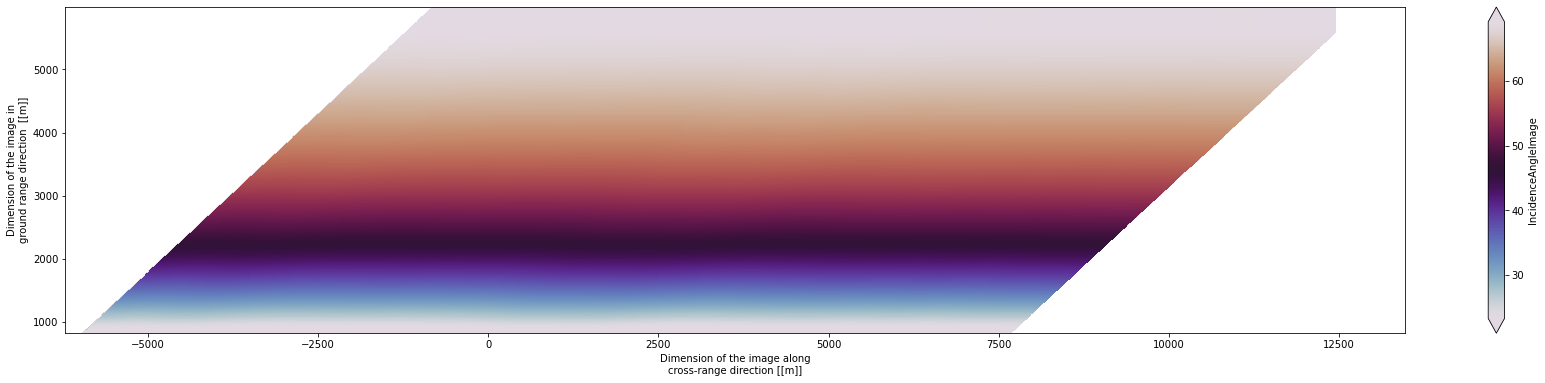

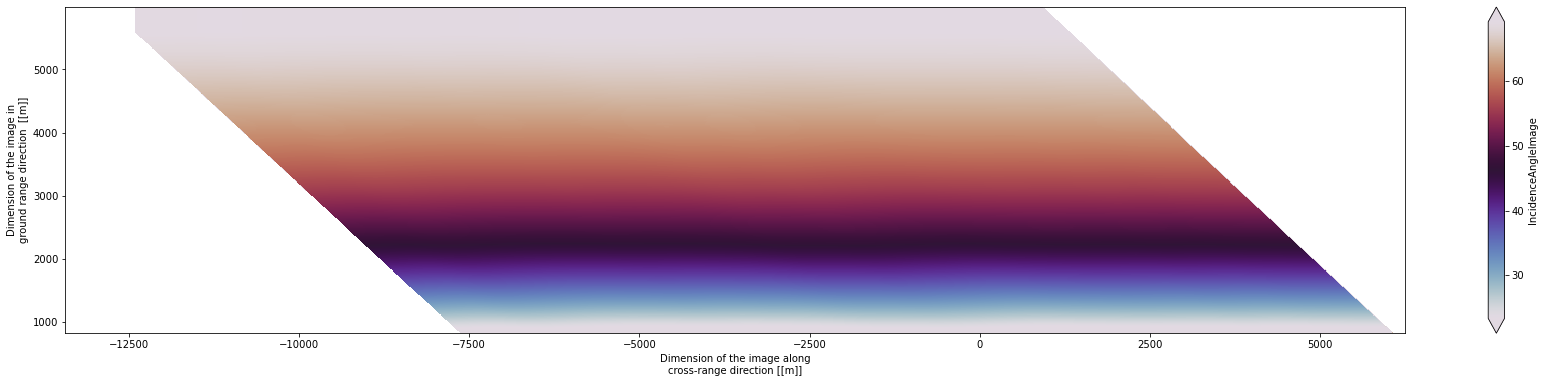

In [135]:
ax1 = ds_ml[19].IncidenceAngleImage.plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                        cmap='twilight',

                      )
ax1 = ds_ml[20].IncidenceAngleImage.plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                        cmap='twilight',

                      )

In [138]:
test=xr.merge([ds_ml[19].IncidenceAngleImage, ds_ml[20].IncidenceAngleImage], join='outer')
test

<xarray.Dataset>
Dimensions:              (CrossRange: 4918, GroundRange: 645)
Coordinates:
  * CrossRange           (CrossRange) float64 -1.343e+04 ... 1.346e+04
  * GroundRange          (GroundRange) float32 832.0 840.0 ... 5.984e+03
Data variables:
    IncidenceAngleImage  (CrossRange, GroundRange) float64 nan nan ... nan nan

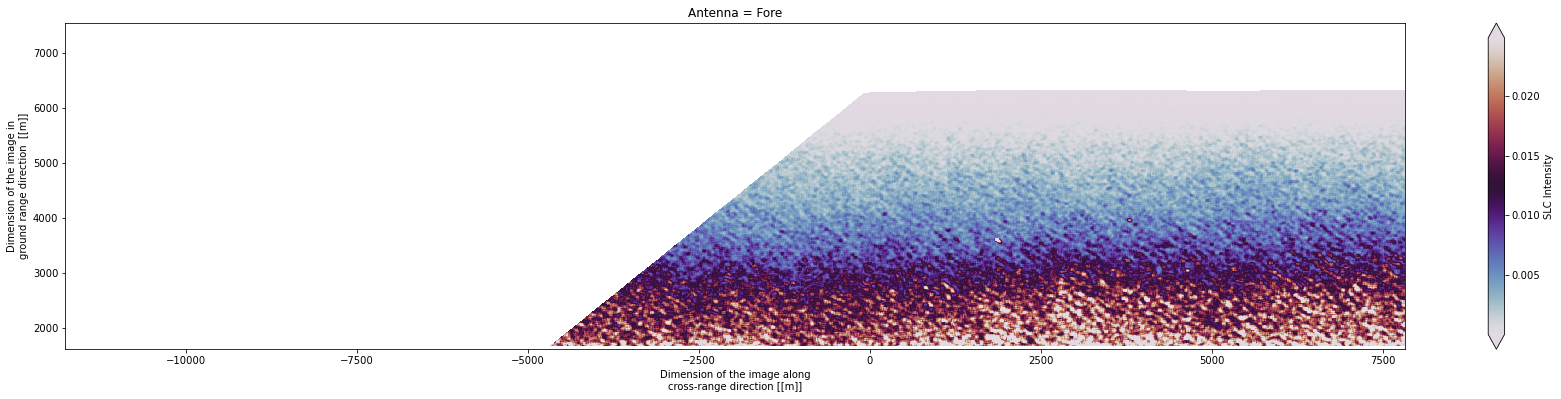

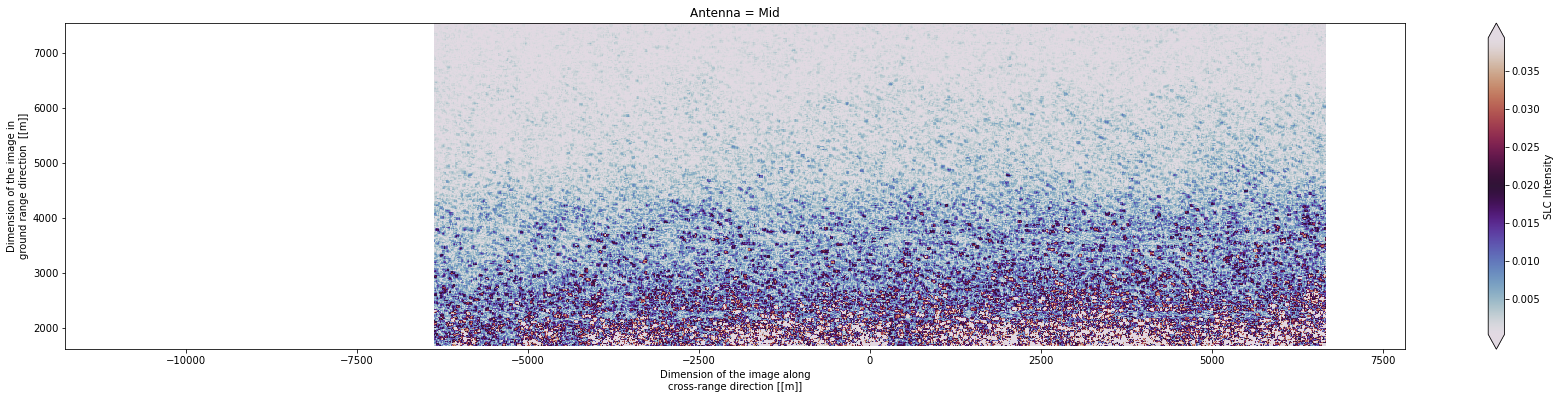

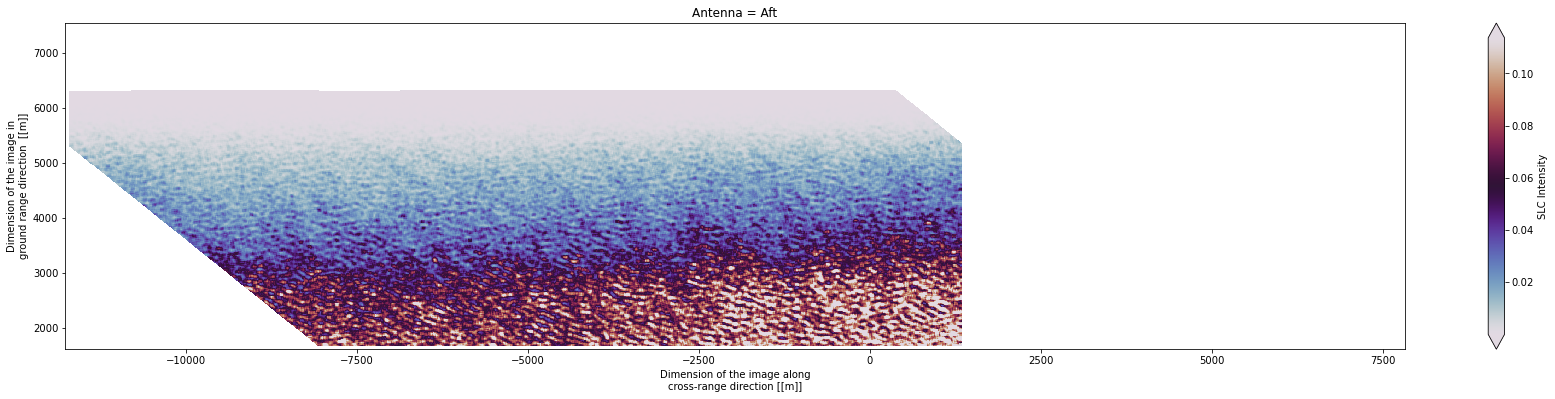

In [234]:
ax1 = test.Intensity.sel(Antenna='Fore').plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                        cmap='twilight',

                      )
ax1 = test.Intensity.sel(Antenna='Mid').plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                        cmap='twilight',

                      )
ax1 = test.Intensity.sel(Antenna='Aft').plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                        cmap='twilight',

                      )

In [232]:
test_ds1=xr.Dataset()
test_ds1['Intensity'] = ds_ml[18].Intensity
test_ds2=xr.Dataset()
test_ds2['Intensity'] = ds_ml[19].Intensity
test_ds3=xr.Dataset()
test_ds3['Intensity'] = ds_ml[20].Intensity

In [233]:
#test = merge_beams(ds_ml, antenna_ident)
#test = merge_beams({18:ds_ml[18],19:ds_ml[19]}, [antenna_ident[0],antenna_ident[1]])
test = merge_beams({18:test_ds1,19:test_ds2,20:test_ds3}, antenna_ident)

In [203]:
ds_ml[18]['Coherence'] = ds_ml[18].Coherence.T

In [214]:
ds_ml[20].CrossRange

<xarray.DataArray 'CrossRange' (CrossRange: 2459)>
array([-13429., -13421., -13413., ...,   6219.,   6227.,   6235.],
      dtype=float32)
Coordinates:
  * CrossRange  (CrossRange) float32 -1.343e+04 -1.342e+04 ... 6.235e+03
Attributes:
    long_name:  Dimension of the image along cross-range direction
    units:      [m]

In [215]:
ds_ml[19].CrossRange

<xarray.DataArray 'CrossRange' (CrossRange: 2459)>
array([-6208., -6200., -6192., ..., 13440., 13448., 13456.], dtype=float32)
Coordinates:
  * CrossRange  (CrossRange) float32 -6.208e+03 -6.2e+03 ... 1.345e+04 1.346e+04
Attributes:
    long_name:  Dimension of the image along cross-range direction
    units:      [m]

In [221]:
def merge_beams(ds_dict, antenna_id):

    ds_level1 = xr.concat(objs=list(ds_dict.values()),
                          dim='Antenna',
                          join='outer',
                          coords='all',
                         )
    
    ds_level1 = ds_level1.assign_coords(Antenna=('Antenna', antenna_id))
    key_list = list(ds_dict.keys())
    #ds_level1.coords['latitude'] = xr.merge(
    #        [ds_dict[key_list[0]].LatImage.dropna(dim='CrossRange'),
    #         ds_dict[key_list[1]].LatImage.dropna(dim='CrossRange'),
    #         ds_dict[key_list[2]].LatImage.dropna(dim='CrossRange')],
    #        ).LatImage
    #ds_level1.coords['longitude'] = xr.merge(
    #        [ds_dict[key_list[0]].LonImage.dropna(dim='CrossRange'),
    #         ds_dict[key_list[1]].LonImage.dropna(dim='CrossRange'),
    #         ds_dict[key_list[2]].LonImage.dropna(dim='CrossRange')],
    #        ).LonImage

    return ds_level1